Для создания нашей двуязыковой суммаризации мы будем использовать Multilingual Amazon Reviews Corpus. Этот корпус состоит из отзывов о товарах Amazon на шести языках и обычно используется для тестирования многоязыковых классификаторов. Однако, поскольку каждый отзыв сопровождается коротким заголовком, мы можем использовать заголовки в качестве целевых резюме для обучения нашей модели! Чтобы начать работу, давайте загрузим английские и испанские подмножества из Hugging Face Hub:

In [1]:
# модуль с датасетами
from datasets import load_dataset

d:\Helper\MLBazyak\chemp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import Dataset, DatasetDict
import os
import random

def load_custom_dataset(dataset_path):
    data = {"train": [], "validation": [], "test": []}
    
    # Собираем все примеры
    samples = []
    for dir_name in os.listdir(dataset_path):
        dir_path = os.path.join(dataset_path, dir_name)
        if os.path.isdir(dir_path):
            text_path = os.path.join(dir_path, "text.txt")
            annotation_path = os.path.join(dir_path, "annotation.txt")
            
            if os.path.exists(text_path) and os.path.exists(annotation_path):
                with open(text_path, "r", encoding="utf-8") as f:
                    text = f.read().strip()
                
                with open(annotation_path, "r", encoding="utf-8") as f:
                    summary = f.read().strip()
                
                samples.append({
                    "text": text,
                    "summary": summary,
                    "id": dir_name
                })

    # Разделяем на train/val/test (80/10/10)
    random.shuffle(samples)
    n = len(samples)
    data["train"] = samples[:int(0.8*n)]
    data["validation"] = samples[int(0.8*n):int(0.9*n)]
    data["test"] = samples[int(0.9*n):]

    # Создаем DatasetDict
    return DatasetDict({
        split: Dataset.from_list(data[split])
        for split in ["train", "validation", "test"]
    })

# Использование
dataset = load_custom_dataset("../Data/DATASET/")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'id'],
        num_rows: 801
    })
    validation: Dataset({
        features: ['text', 'summary', 'id'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'summary', 'id'],
        num_rows: 101
    })
})


In [15]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Text: {example['text'][:300]}...'")
        print(f"'>> Summary: {example['summary']}'")


show_samples(dataset)


'>> Text: 0    В последние годы очень сильно выросла сложност...
Name: text, dtype: object...'
'>> Summary: 0    В работе рассмотрены способы создания современ...
Name: summary, dtype: object'

'>> Text: 0    Всему миру известен данный модный дом, каждая ...
Name: text, dtype: object...'
'>> Summary: 0    Как появилось имя Коко Шанель? Кто она, создат...
Name: summary, dtype: object'

'>> Text: 0    Обладает ли искусственный интеллект (ИИ) субъе...
Name: text, dtype: object...'
'>> Summary: 0    Рассматривается проблема возможной субъектност...
Name: summary, dtype: object'


In [4]:
dataset.set_format("pandas")
df = dataset["train"][:]
# Show counts for top 20 products
df["summary"].value_counts()[:20]

summary
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [37]:
dataset = dataset.filter(lambda x: len(x["summary"].split()) > 6)
dataset = dataset.filter(lambda x: len(x["text"].split()) > 100)

Filter: 100%|██████████| 101/101 [00:00<00:00, 5904.59 examples/s]


Реализуем простую трансформерную архитектуру с использованием PyTorch:

In [38]:
from transformers import T5Tokenizer

model_checkpoint = "google/mt5-small"
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)

In [39]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [336, 259, 28387, 11807, 287, 62893, 295, 12507, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [40]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁', 'loved', '▁reading', '▁the', '▁Hung', 'er', '▁Games', '!', '</s>']

In [47]:
max_input_length = 112
max_target_length = 100


def preprocess_function(examples):
    for i in range(examples.shape[0]):
        model_inputs = tokenizer(
            examples["text"][i],
            max_length=max_input_length,
            truncation=True,
        )
        labels = tokenizer(
            examples["summary"][i], max_length=max_target_length, truncation=True
        )
        model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [48]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/785 [00:09<?, ? examples/s]


ArrowInvalid: Column 2 named labels expected length 112 but got length 100

In [10]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# 1. Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Модифицируем класс модели
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class Summarizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Энкодер BERT
        self.encoder = BertModel.from_pretrained("bert-base-uncased")
        
        # Эмбеддинги для декодера
        self.decoder_embeddings = nn.Embedding(
            num_embeddings=self.encoder.config.vocab_size,
            embedding_dim=self.encoder.config.hidden_size,
            padding_idx=self.encoder.config.pad_token_id
        )
        
        # Декодер Transformer
        self.decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(
                d_model=self.encoder.config.hidden_size,
                nhead=8
            ),
            num_layers=3
        )
        
        # Финальный слой
        self.fc = nn.Linear(
            self.encoder.config.hidden_size,
            self.encoder.config.vocab_size
        )

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        # Кодирование текста
        encoder_output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state  # [batch_size, seq_len, hidden_dim]
        
        # Эмбеддинги для декодера
        decoder_embeds = self.decoder_embeddings(decoder_input_ids)  # [batch_size, tgt_seq_len, hidden_dim]
        
        # Декодирование
        decoder_output = self.decoder(
            tgt=decoder_embeds.transpose(0, 1),  # [tgt_seq_len, batch_size, hidden_dim]
            memory=encoder_output.transpose(0, 1),  # [src_seq_len, batch_size, hidden_dim]
            memory_key_padding_mask=~attention_mask.bool()
        ).transpose(0, 1)  # [batch_size, tgt_seq_len, hidden_dim]
        
        return self.fc(decoder_output)

# Инициализация
model = Summarizer().to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Using device: cpu


 Обучение модели

In [12]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import torch

# 1. Правильная токенизация данных
def preprocess_function(examples):
    # Токенизация текста (входные данные)
    inputs = tokenizer(
        examples["text"],
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    
    # Токенизация аннотаций (целевые данные)
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(
            examples["summary"],
            max_length=128,
            truncation=True,
            padding="max_length"
        )
    
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"]
    }

# 2. Применяем преобразования
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["text", "summary", "id"]
).with_format("torch")

# 3. Создаем DataLoader с правильным коллатором
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(
    tokenized_datasets["train"],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=True
)

# 4. Исправленный цикл обучения
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    model.train()
    for batch in train_loader:
        # Перенос данных на устройство
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Проверка устройств
        # print(f"Model device: {model.device}")
        print(f"Batch devices: { {k: v.device for k, v in batch.items()} }")
        
        # Forward pass
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            decoder_input_ids=batch["labels"][:, :-1]
        )
        
        # Расчет потерь
        loss = nn.CrossEntropyLoss()(
            outputs.view(-1, outputs.size(-1)),
            batch["labels"][:, 1:].contiguous().view(-1)
        )
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Loss: {loss.item()}")

Map: 100%|██████████| 101/101 [00:06<00:00, 15.78 examples/s]


Batch devices: {'input_ids': device(type='cpu'), 'attention_mask': device(type='cpu'), 'labels': device(type='cpu')}
Loss: 10.507205963134766
Batch devices: {'input_ids': device(type='cpu'), 'attention_mask': device(type='cpu'), 'labels': device(type='cpu')}
Loss: 9.765242576599121
Batch devices: {'input_ids': device(type='cpu'), 'attention_mask': device(type='cpu'), 'labels': device(type='cpu')}
Loss: 9.233859062194824
Batch devices: {'input_ids': device(type='cpu'), 'attention_mask': device(type='cpu'), 'labels': device(type='cpu')}
Loss: 8.824164390563965
Batch devices: {'input_ids': device(type='cpu'), 'attention_mask': device(type='cpu'), 'labels': device(type='cpu')}
Loss: 8.570368766784668
Batch devices: {'input_ids': device(type='cpu'), 'attention_mask': device(type='cpu'), 'labels': device(type='cpu')}
Loss: 8.214201927185059
Batch devices: {'input_ids': device(type='cpu'), 'attention_mask': device(type='cpu'), 'labels': device(type='cpu')}
Loss: 7.919087886810303
Batch device

In [24]:
def generate_summary(model, tokenizer, text, max_length=128, device='cpu'):
    # Токенизация входного текста
    inputs = tokenizer(
        text,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    
    # Начальный токен для генерации
    decoder_input = torch.tensor([[tokenizer.cls_token_id]]).to(device)
    
    # Генерация токенов шаг за шагом
    for _ in range(max_length):
        outputs = model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            decoder_input_ids=decoder_input
        )
        
        # Выбираем следующий токен с максимальной вероятностью
        next_token = outputs[0, -1].argmax(dim=-1).unsqueeze(0)
        
        # Добавляем токен к последовательности
        decoder_input = torch.cat([decoder_input, next_token.unsqueeze(0)], dim=-1)
        
        # Останавливаемся при достижении [SEP]
        if next_token == tokenizer.sep_token_id:
            break
    
    # Преобразуем токены в текст
    summary = tokenizer.decode(
        decoder_input[0].cpu().numpy(),
        skip_special_tokens=True
    )
    
    return summary

In [25]:
# Загрузка статьи из файла
article = open("../Data/DATASET/43/text.txt", "r", encoding="utf-8").read()

# Генерация итога
model.eval()  # Переводим модель в режим оценки
with torch.no_grad():
    summary = generate_summary(
        model=model,
        tokenizer=tokenizer,
        text=article,
        device=device  # 'cpu' или 'cuda'
    )

print("Исходная статья:")
print(article[:300] + "...")  # Выводим первые 500 символов
print("\nСгенерированный итог:")
print(summary)

Исходная статья:
При построении современных распределенных компьютерных 
систем широко используется сервис-ориентированная архитектура (СОА). Для практической реализации систем с СОА применяют технологии Web-сервисов (Web-служб) [1–3.
Web-сервисы предоставляют Web-услуги в рамках слабосвязанных Webприложений. К т...

Сгенерированный итог:
в


In [19]:
import matplotlib.pyplot as plt

Annotation 1: В электронном учебнике изложены основные разделы к...
Annotation 2: Большинство современных Node.js-проектов написаны ...
Annotation 3: В статье рассмотрены причины использования техноло...
Annotation 4: Данная работа посвящена созданию сайта, который по...
Annotation 5: В статье рассматриваются основные принципы работы ...


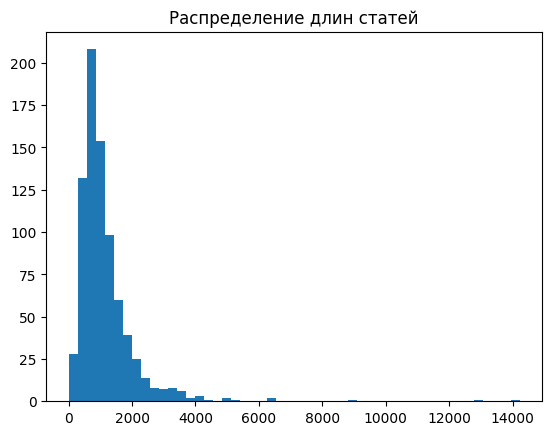

In [20]:
# Проверка аннотаций
for i in range(1, 6):
    with open(f"../Data/DATASET/{i}/annotation.txt", "r", encoding="utf-8") as f:
        annotation = f.read()
        print(f"Annotation {i}: {annotation[:50]}...")

# Статистика длины текстов
lengths = []
for sample in dataset["train"]:
    lengths.append(len(sample["text"].split()))
plt.hist(lengths, bins=50)
plt.title("Распределение длин статей")
plt.show()